In [15]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

In [16]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [17]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [18]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [19]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)

In [20]:
# Create a testing set with 25 images per class
num_images_per_class = 40

def create_testing_set(dataframe, num_images_per_class):
    test_indices = []
    for cls in dataframe['class_code'].unique():
        class_indices = dataframe[dataframe['class_code'] == cls].index[:num_images_per_class].tolist()
        test_indices.extend(class_indices)
    return test_indices

test_indices = create_testing_set(DataSolarModules, num_images_per_class)
data_test = np.array(test_indices)

# Create a training set with the remaining images
data_train = np.setdiff1d(np.arange(len(images)), data_test)

In [21]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [23]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4704 - loss: 1.9163

I0000 00:00:1716670714.135457   31950 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716670714.448525   31962 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716670714.650769   31963 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716670714.679737   31956 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 336 bytes spill stores, 344 bytes spill loads

I0000 00:00:1716670714.731475   31955 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716670715.038463   31971 

255/255 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.4704 - loss: 1.9160 - val_accuracy: 0.4852 - val_loss: 1.7477
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4902 - loss: 1.7155 - val_accuracy: 0.5258 - val_loss: 1.5473
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5489 - loss: 1.5268 - val_accuracy: 0.5449 - val_loss: 1.5148
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6006 - loss: 1.3508 - val_accuracy: 0.6251 - val_loss: 1.2395
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6224 - loss: 1.2536 - val_accuracy: 0.6288 - val_loss: 1.1874
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 1.2430 - val_accuracy: 0.6454 - val_loss: 1.1410
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6278 - loss: 1.1799 - val_accuracy: 0.6451 - val_loss: 1.1825
Epoch 8/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6440 - loss: 1.1626 - val_accuracy: 0.6580 - va

I0000 00:00:1716670726.701304   33469 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716670726.719713   33492 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads



Score for fold 1: loss of 0.8652202486991882; compile_metrics of 73.78610968589783%
Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7443 - loss: 0.7962 - val_accuracy: 0.7747 - val_loss: 0.6912
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7584 - loss: 0.7662 - val_accuracy: 0.7803 - val_loss: 0.6850
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7563 - loss: 0.7593 - val_accuracy: 0.7809 - val_loss: 0.6843
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7651 - loss: 0.7344 - val_accuracy: 0.7667 - val_loss: 0.7330
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7657 - loss: 0.7181 - val_accuracy: 0.7732 - val_loss: 0.7081
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7646 - loss: 0.7297 - val_accuracy: 0.7741 - val_loss: 0.7083
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7758 - loss: 0.6720 - val_accuracy: 0.7806 - val_loss: 0.7165
Epoch 8/25
255/255 ━

I0000 00:00:1716670745.317680   35102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716670745.386925   35112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716670745.621509   35116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716670745.718004   35110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716670745.844232   35121 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 336 bytes spill stores, 344 bytes spill loads

I0000 00:00:1716670746.080583   35106 asm_

255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8230 - loss: 0.5758 - val_accuracy: 0.8841 - val_loss: 0.3578
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8297 - loss: 0.5203 - val_accuracy: 0.8712 - val_loss: 0.3888
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8364 - loss: 0.5002 - val_accuracy: 0.8746 - val_loss: 0.3732
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8346 - loss: 0.5128 - val_accuracy: 0.8607 - val_loss: 0.4086
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8367 - loss: 0.4933 - val_accuracy: 0.8740 - val_loss: 0.3883
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8454 - loss: 0.4904 - val_accuracy: 0.8629 - val_loss: 0.4037
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8506 - loss: 0.4593 - val_accuracy: 0.8543 - val_loss: 0.4214
Epoch 8/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8491 - loss: 0.4636 - val_accuracy: 0.8463 - va

I0000 00:00:1716670757.140287   36615 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716670757.142796   36603 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads



Score for fold 3: loss of 0.5573869347572327; compile_metrics of 82.87734389305115%
Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8673 - loss: 0.4146 - val_accuracy: 0.9275 - val_loss: 0.2343
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8698 - loss: 0.3872 - val_accuracy: 0.9379 - val_loss: 0.2019
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8805 - loss: 0.3532 - val_accuracy: 0.9296 - val_loss: 0.2148
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8921 - loss: 0.3339 - val_accuracy: 0.9109 - val_loss: 0.2736
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8787 - loss: 0.3606 - val_accuracy: 0.9216 - val_loss: 0.2332
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8844 - loss: 0.3397 - val_accuracy: 0.9167 - val_loss: 0.2465
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8789 - loss: 0.3584 - val_accuracy: 0.9170 - val_loss: 0.2461
Epoch 8/25
255/255 ━

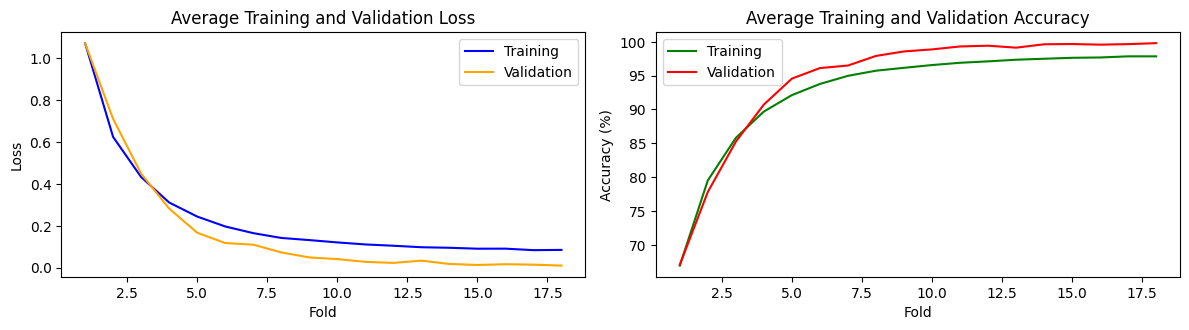

In [24]:
plt.figure(figsize=(12, 6))

# Plotting average training and validation losses
plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue', label='Training')
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange', label='Validation')
plt.title('Average Training and Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

# Plotting average training and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green', label='Training')
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red', label='Validation')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.9877 - loss: 0.0423
Test loss: 0.030141126364469528
Test accuracy: 0.9916666746139526


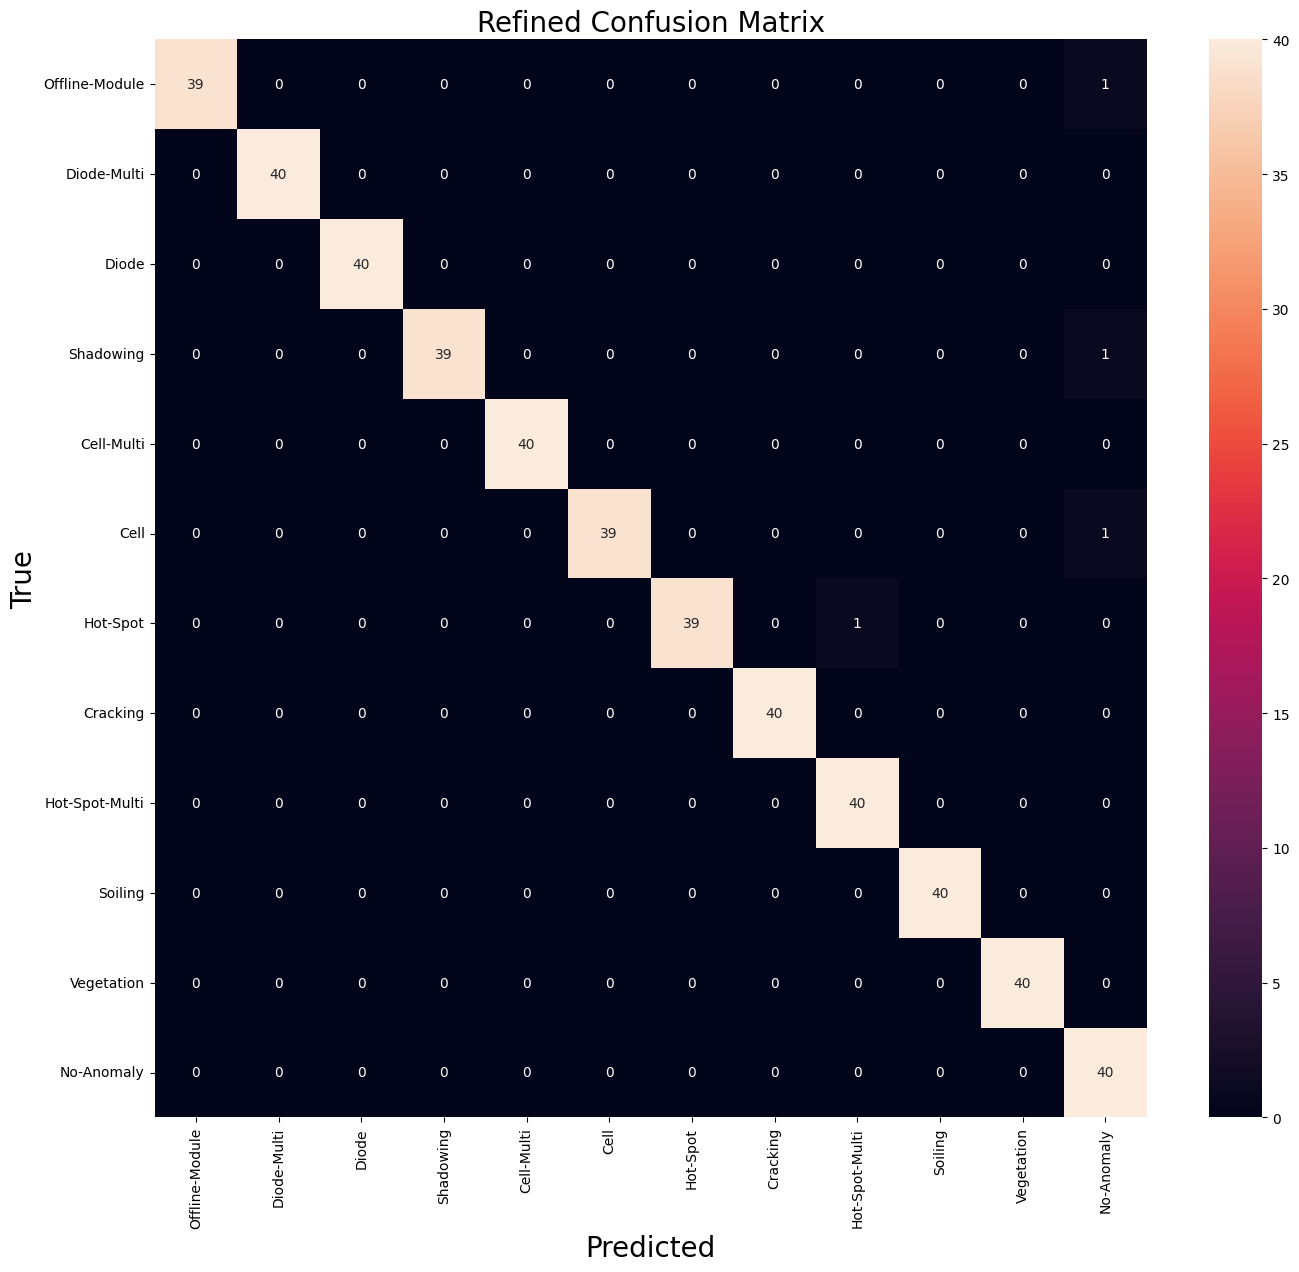

In [26]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [27]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [28]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics    Values
0           Accuracy  0.991667
1  Average Precision  0.992154
2     Average Recall  0.991667
3   Average F1 Score  0.991740


In [29]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision  Recall  F1 Score
0   Offline-Module   1.000000   0.975  0.987342
1      Diode-Multi   1.000000   1.000  1.000000
2            Diode   1.000000   1.000  1.000000
3        Shadowing   1.000000   0.975  0.987342
4       Cell-Multi   1.000000   1.000  1.000000
5             Cell   1.000000   0.975  0.987342
6         Hot-Spot   1.000000   0.975  0.987342
7         Cracking   1.000000   1.000  1.000000
8   Hot-Spot-Multi   0.975610   1.000  0.987654
9          Soiling   1.000000   1.000  1.000000
10      Vegetation   1.000000   1.000  1.000000
11      No-Anomaly   0.930233   1.000  0.963855
